[x] agregagar estacao tubo com pontos de rua   
[x] eliminar linhas turismo, madrugueiro e outros   
[x] eliminar faixas de horario da madrugada (0-4)  
[x] gerar correlacoes por faixa de horario   
[x] revisar correlacoes da janela rolante   

In [1]:
import  re
import pandas as pd
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:.2f}'.format

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sshtunnel
import mysql.connector as connection

import folium
import geopandas as gpd
from shapely.geometry import LineString
from folium.plugins import HeatMap
from shapely.geometry import Point
from folium.plugins import MarkerCluster
from folium import plugins

### Load and preprocess data

In [2]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

[x] agregagar estacao tubo com pontos de rua   
[x] eliminar linhas turismo, madrugueiro e outros   

In [3]:

## removing the hours between 0 and 4 (dawn)
vw_event = pd.read_parquet("events.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event = vw_event.query("hour not in [0,1,2,3,4]")

## removing the bus stop types (others, dawn bus and tourism line)
dim_bus_stop = pd.read_parquet("dim_bus_stop.parquet").query("type_norm not in (['Others','Dawn bus','Tourism line'])").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where( (dim_bus_stop.type_norm == 'Bus terminal'),  dim_bus_stop.name , '')

dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)

[x] agregagar pontos do terminal como ponto unico ( dummy legacy id )

In [4]:
# creating dummy ids for each terminal/platform
## here the dummy ids are just the sum of the ids of all points in the same bus station. It's a simple rule and it might work as the sum will generate a big number not related with the other points.

terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()

In [5]:
# The following three bus stops were identified as platforms/Bust Terminal, is that right? Perhaps a fix will be needed here.

# Estação PUC (Oficinas / Uberaba)	141011
# 1	Estação PUC (Portão / Centro)	141010
# 2	Rua Lea Moreira de Souza Moura, 11 - Cidade Industrial	170154


terminais_dummy_ids

,name_normalized,dummy_legacy_id
0,Estação PUC (Oficinas / Uberaba),141011
1,Estação PUC (Portão / Centro),141010
2,"Rua Lea Moreira de Souza Moura, 11 - Cidade Industrial",170154
3,Terminal Bairro Alto,1149184
4,Terminal Barreirinha,1050998
5,Terminal Boa Vista,729432
6,Terminal Boqueirão,1778660
7,Terminal CIC,1376050
8,Terminal Cabral,1705856
9,Terminal Cachoeira,109142


In [6]:
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')

In [7]:
dim_bus_stop#.query("type_norm == 'Bus terminal' ")

,id,legacy_id,name,latitude,longitude,type,type_norm,name_normalized,dummy_legacy_id
0,7139,101001,Praça Tiradentes - 870 - São Braz,-25.43,-49.27,Novo mobiliário,Street bus stop,,nan
1,7140,101002,Praça Tiradentes - 865 - Jd Esplanada,-25.43,-49.27,Novo mobiliário,Street bus stop,,nan
2,7141,101003,Praça Tiradentes - 875 - Bigorrilho,-25.43,-49.27,Novo mobiliário,Street bus stop,,nan
3,7142,101004,Praça Tiradentes - 876 - Savóia,-25.43,-49.27,Novo mobiliário,Street bus stop,,nan
4,7143,101005,Praça Tiradentes - 207 - Cabral/ Osório - 260 - Mal.Hermes/Sta.Efigênia,-25.43,-49.27,Novo mobiliário,Street bus stop,,nan
...,...,...,...,...,...,...,...,...,...
6857,15448,190323,"Rua José Culpi, 520 - Butiatuvinha",-25.39,-49.36,Chapéu chinês,Street bus stop,,nan
6858,15449,190339,"Rua José Tomasi, 445 - Santa Felicidade",-25.41,-49.34,Chapéu chinês,Street bus stop,,nan
6859,15450,190344,"Rua José Bepe Luca, 1 - São Braz",-25.42,-49.34,Chapéu chinês,Street bus stop,,nan
6860,15451,190791,"Rua Carlos Chagas, 798 - São Braz",-25.42,-49.34,Chapéu chinês,Street bus stop,,nan


In [8]:
# just fill the dummy_legacy_id's with the legacy_id's for all remaining null fields, 

dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

In [9]:
dim_bus_stop.head(5)

,id,legacy_id,name,latitude,longitude,type,type_norm,name_normalized,dummy_legacy_id
0,7139,101001,Praça Tiradentes - 870 - São Braz,-25.43,-49.27,Novo mobiliário,Street bus stop,,101001
1,7140,101002,Praça Tiradentes - 865 - Jd Esplanada,-25.43,-49.27,Novo mobiliário,Street bus stop,,101002
2,7141,101003,Praça Tiradentes - 875 - Bigorrilho,-25.43,-49.27,Novo mobiliário,Street bus stop,,101003
3,7142,101004,Praça Tiradentes - 876 - Savóia,-25.43,-49.27,Novo mobiliário,Street bus stop,,101004
4,7143,101005,Praça Tiradentes - 207 - Cabral/ Osório - 260 - Mal.Hermes/Sta.Efigênia,-25.43,-49.27,Novo mobiliário,Street bus stop,,101005


In [10]:
vw_event = vw_event.merge(dim_bus_stop.filter(['legacy_id','dummy_legacy_id']), on='legacy_id')

In [11]:
vw_event.head(5)

,line_code,line_name,vehicle,latitude,longitude,name,legacy_id,type,seq,itinerary_id,event_timestamp,base_date,hour,dummy_legacy_id
0,265,AHÚ / LOS ANGELES,HI850,-25.45,-49.31,"Rua Jaime Veiga, 302 - Seminário",180899,Novo mobiliário,0,596,2022-07-12 05:17:33,2022-07-12,5,180899
1,265,AHÚ / LOS ANGELES,HI850,-25.45,-49.31,"Rua Jaime Veiga, 302 - Seminário",180899,Novo mobiliário,33,597,2022-07-12 06:42:00,2022-07-12,6,180899
2,265,AHÚ / LOS ANGELES,HI850,-25.45,-49.31,"Rua Jaime Veiga, 302 - Seminário",180899,Novo mobiliário,33,597,2022-07-12 08:06:08,2022-07-12,8,180899
3,265,AHÚ / LOS ANGELES,HI850,-25.45,-49.31,"Rua Jaime Veiga, 302 - Seminário",180899,Novo mobiliário,33,597,2022-07-12 09:22:33,2022-07-12,9,180899
4,265,AHÚ / LOS ANGELES,HI850,-25.45,-49.31,"Rua Jaime Veiga, 302 - Seminário",180899,Novo mobiliário,33,597,2022-07-12 10:42:16,2022-07-12,10,180899


In [57]:
# ----------------------------------------------------------
# Contabiliza a passagem dos veículos nos pontos de ônibus
# Notice that here we are using dummy legacy id's so all bus stops in the same bus terminal will be grouped as a single point
# ----------------------------------------------------------
paradas = []
for legacy_id in vw_event["dummy_legacy_id"].unique():
    aux = vw_event.query("dummy_legacy_id == @legacy_id").copy()
    aux["bus_availability"] = 1
    aux.index = aux["event_timestamp"]
    aux.sort_index(inplace = True)
    aux = aux.rolling(window = "10min", min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
    aux.reset_index(inplace = True)
    aux["dummy_legacy_id"] = legacy_id
    aux["hour"] = aux["event_timestamp"].dt.hour
    paradas.append(aux)
paradas = pd.concat(paradas, ignore_index = True)

In [60]:
## Terminal Portão - 1706050
paradas.query("dummy_legacy_id == 1706050").sample(5)

,event_timestamp,bus_availability,dummy_legacy_id,hour
483591,2022-07-14 07:38:49,31.00,1706050,7
483769,2022-07-14 08:47:53,24.00,1706050,8
483337,2022-07-14 06:03:33,22.00,1706050,6
482846,2022-07-13 18:31:31,25.00,1706050,18
483150,2022-07-13 22:00:22,9.00,1706050,22


In [61]:
paradas.bus_availability.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
bus_availability,2371313.00,2.43,3.12,1.00,1.00,1.00,3.00,46.00


In [62]:
df = pd.merge(paradas, dim_bus_stop, on = "dummy_legacy_id")

In [63]:
# MERGE BUS TERMINAL POINTS

df_bus_availability = df.groupby(['dummy_legacy_id','name_normalized','type_norm','hour']).agg(bus_availability=('bus_availability','mean')).reset_index()

In [64]:
df_bus_availability

,dummy_legacy_id,name_normalized,type_norm,hour,bus_availability
0,101001,,Street bus stop,5,1.00
1,101001,,Street bus stop,6,1.00
2,101001,,Street bus stop,7,1.00
3,101001,,Street bus stop,8,1.00
4,101001,,Street bus stop,9,1.00
...,...,...,...,...,...
118875,4599877,Terminal Pinheirinho,Bus terminal,19,25.80
118876,4599877,Terminal Pinheirinho,Bus terminal,20,15.64
118877,4599877,Terminal Pinheirinho,Bus terminal,21,13.49
118878,4599877,Terminal Pinheirinho,Bus terminal,22,13.86


In [65]:
df_bus_availability.query("type_norm == 'Bus terminal'").groupby(["type_norm","hour"]).bus_availability.describe().transpose()

type_norm Bus terminal                                                        \
hour                5     6     7     8     9     10    11    12    13    14   
count            27.00 27.00 27.00 26.00 27.00 27.00 27.00 27.00 26.00 27.00   
mean              6.25 11.34 12.36 11.31  6.60  6.12  6.10  6.15  6.44  6.22   
std               4.32  7.87  8.87  7.44  4.28  3.84  3.82  3.93  3.86  3.88   
min               1.00  1.00  1.11  1.29  1.00  1.00  1.00  1.00  1.00  1.00   
25%               3.91  6.54  6.59  5.95  3.65  3.65  3.36  3.81  3.65  3.75   
50%               5.11  9.34  9.96  9.71  5.75  5.28  5.27  5.18  5.24  5.27   
75%               7.83 14.14 16.03 14.66  8.62  8.11  8.07  7.90  8.24  8.35   
max              19.37 30.53 33.22 27.13 16.87 15.57 15.23 15.55 15.59 15.33   

type_norm                                                        
hour         15    16    17    18    19    20    21    22    23  
count     27.00 26.00 26.00 27.00 27.00 27.00 27.00 26.00 27.00  
mean       6.33  8.77 11.22 10.84  9.93  6.31  5.49  5.73  5.48  
std        4.01  5.33  7.35  7.41  6.64  3.83  3.31  3.39  3.31  
min        1.00  1.07  1.00  1.00  1.00  1.00  1.00  1.00  1.00  
25%        3.76  5.17  6.06  5.77  5.84  3.77  3.50  3.34  3.66  
50%        5.43  7.73  9.56  9.26  7.98  5.44  4.77  4.91  4.75  
75%        8.46 11.37 14.81 15.00 14.00  8.05  6.74  7.18  6.75  
max       15.64 20.25 27.70 27.24 25.80 15.64 13.49 13.86 13.71

In [66]:
df_bus_availability.query("type_norm == 'Tube station'").groupby(["type_norm","hour"]).bus_availability.describe().transpose()

type_norm Tube station                                                   \
hour                5      6      7      8      9      10     11     12   
count           248.00 288.00 288.00 288.00 285.00 286.00 286.00 285.00   
mean              1.53   2.83   3.21   2.84   1.92   1.71   1.71   1.71   
std               0.52   1.35   1.52   1.28   0.83   0.68   0.68   0.66   
min               1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
25%               1.20   1.91   2.17   1.97   1.32   1.19   1.20   1.24   
50%               1.44   2.45   2.80   2.44   1.71   1.45   1.44   1.50   
75%               1.73   3.31   3.98   3.67   2.27   2.10   2.04   2.06   
max               3.91   7.36   7.87   7.61   4.56   3.69   3.80   3.72   

type_norm                                                                 \
hour          13     14     15     16     17     18     19     20     21   
count     285.00 284.00 285.00 286.00 287.00 287.00 286.00 286.00 285.00   
mean        1.72   1.72   1.79   2.35   2.89   2.96   2.42   1.61   1.47   
std         0.68   0.67   0.67   1.02   1.33   1.34   1.09   0.55   0.47   
min         1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
25%         1.25   1.26   1.29   1.54   2.03   2.11   1.60   1.17   1.10   
50%         1.46   1.49   1.63   2.24   2.51   2.62   2.19   1.47   1.29   
75%         2.00   2.04   2.12   2.82   3.53   3.65   2.88   1.95   1.85   
max         3.79   3.62   3.77   6.15   7.63   7.93   6.67   4.22   3.19   

type_norm                
hour          22     23  
count     286.00 286.00  
mean        1.46   1.45  
std         0.48   0.47  
min         1.00   1.00  
25%         1.05   1.07  
50%         1.30   1.28  
75%         1.88   1.75  
max         3.16   3.28

In [67]:
df_bus_availability.query("type_norm == 'Street bus stop'").groupby(["type_norm","hour"]).bus_availability.describe().transpose()

type_norm Street bus stop                                                  \
hour                   5       6       7       8       9       10      11   
count             4938.00 6041.00 6045.00 6053.00 6013.00 5983.00 5962.00   
mean                 1.28    1.43    1.45    1.40    1.23    1.21    1.22   
std                  0.58    0.81    0.81    0.72    0.48    0.44    0.45   
min                  1.00    1.00    1.00    1.00    1.00    1.00    1.00   
25%                  1.00    1.00    1.00    1.00    1.00    1.00    1.00   
50%                  1.00    1.05    1.07    1.06    1.00    1.00    1.00   
75%                  1.38    1.59    1.62    1.53    1.33    1.29    1.29   
max                  9.41   12.69   12.82   12.09    7.80    7.70    7.35   

type_norm                                                                  \
hour           12      13      14      15      16      17      18      19   
count     5998.00 5981.00 6007.00 5971.00 6002.00 6034.00 6033.00 6030.00   
mean         1.23    1.21    1.22    1.22    1.30    1.38    1.40    1.38   
std          0.46    0.44    0.45    0.44    0.56    0.67    0.71    0.65   
min          1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
25%          1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
50%          1.00    1.00    1.00    1.00    1.00    1.07    1.10    1.09   
75%          1.33    1.31    1.31    1.32    1.41    1.54    1.58    1.54   
max          7.40    7.33    7.46    7.30    9.26   10.45   10.48   10.04   

type_norm                                  
hour           20      21      22      23  
count     5997.00 5970.00 5990.00 5927.00  
mean         1.22    1.19    1.18    1.20  
std          0.43    0.39    0.40    0.42  
min          1.00    1.00    1.00    1.00  
25%          1.00    1.00    1.00    1.00  
50%          1.00    1.00    1.00    1.00  
75%          1.33    1.27    1.25    1.30  
max          7.51    6.28    6.67    6.69

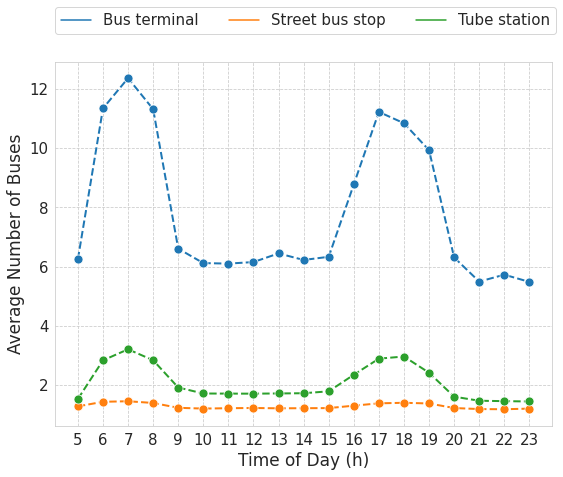

In [68]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.hour, y = df_bus_availability.bus_availability, estimator='mean', err_style = None, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = df_bus_availability.type_norm, hue_order = df_bus_availability["type_norm"].drop_duplicates().sort_values(), palette = sns.color_palette("tab10", 3), ax = axes)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Time of Day (h)", fontsize = 17)
g.set_ylabel("Average Number of Buses", fontsize = 17)
plt.savefig('/home/julio/Downloads/bus_availability.png', format='png', dpi=300);

In [22]:
df_bus_availability

,dummy_legacy_id,name_normalized,type_norm,hour,bus_availability
0,101001,,Street bus stop,5,1.00
1,101001,,Street bus stop,6,1.00
2,101001,,Street bus stop,7,1.00
3,101001,,Street bus stop,8,1.00
4,101001,,Street bus stop,9,1.00
...,...,...,...,...,...
118875,4599877,Terminal Pinheirinho,Bus terminal,19,25.80
118876,4599877,Terminal Pinheirinho,Bus terminal,20,15.64
118877,4599877,Terminal Pinheirinho,Bus terminal,21,13.49
118878,4599877,Terminal Pinheirinho,Bus terminal,22,13.86


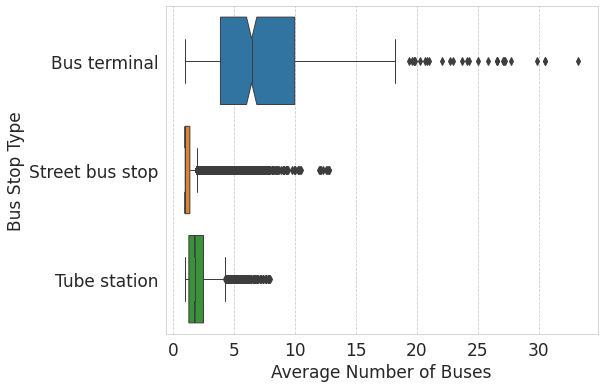

In [69]:
fig, axes = plt.subplots(figsize = (10, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = df_bus_availability.bus_availability, y = df_bus_availability.type_norm, linewidth = 1.0, palette = sns.color_palette("tab10", 3), notch = True, order = df_bus_availability["type_norm"].drop_duplicates().sort_values(), ax = axes)
g.tick_params(labelsize = 17)
g.set_xlabel("Average Number of Buses", fontsize = 17)
g.set_ylabel("Bus Stop Type", fontsize = 17)
#axes.set_xticks(range(0, 35));
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('/home/julio/Downloads/daily_avg_bus_availability.png', format='png', dpi=300)

In [28]:
# ----------------------------------------------------------
# Seleciona apenas os pontos de ônibus e estaçoes tubo na rua
# ----------------------------------------------------------
df_bus_availability.query("type_norm in ['Street bus stop', 'Tube station']", inplace = True)

In [29]:
df_bus_availability_day = (
                            df_bus_availability
                            .groupby(['dummy_legacy_id','type_norm'])
                            .agg(mean_bus_availability = ('bus_availability', 'mean')).sort_values(by='mean_bus_availability', ascending=False)
                        )

In [30]:
df_bus_availability_day.head()

,,mean_bus_availability
dummy_legacy_id,type_norm,
150330,Street bus stop,8.50
150332,Street bus stop,8.48
150751,Street bus stop,8.37
150331,Street bus stop,8.10
170121,Street bus stop,6.09


In [31]:
stat = [df_bus_availability_day.mean_bus_availability.count(),
        df_bus_availability_day.mean_bus_availability.min(), 
        df_bus_availability_day.mean_bus_availability.max(), 
        df_bus_availability_day.mean_bus_availability.quantile(0.25),
        df_bus_availability_day.mean_bus_availability.median(), 
        df_bus_availability_day.mean_bus_availability.quantile(0.75),
        df_bus_availability_day.mean_bus_availability.mean(), 
        df_bus_availability_day.mean_bus_availability.std()
        ]

df_bus_availability_day.mean_bus_availability.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
mean_bus_availability,6386.00,1.31,0.55,1.00,1.00,1.08,1.41,8.50


In [32]:
# ----------------------------------------------------------
# Seleciona apenas os outliers: Q3 + 1,5 * IIQ
# ----------------------------------------------------------
top = df_bus_availability_day.query("mean_bus_availability >= {0}".format(stat[5] + 1.5 * (stat[5] - stat[3])))

In [33]:
top.mean_bus_availability.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
mean_bus_availability,493.00,2.80,0.92,2.03,2.25,2.50,3.07,8.50


In [34]:
top = top.reset_index()

In [35]:
top.head(2)

,dummy_legacy_id,type_norm,mean_bus_availability
0,150330,Street bus stop,8.50
1,150332,Street bus stop,8.48


In [36]:
# -------------------------------------------------
# Constrói os agrupamentos a partir dos outliers
# -------------------------------------------------
base_date_0 = "2022-07-11"
base_date_1 = "2022-07-15"
ssh_username = "julio"
ssh_password = "jfzrpg93"

tunnel = sshtunnel.SSHTunnelForwarder(("200.134.10.26", 22), ssh_username = ssh_username, ssh_password = ssh_password, remote_bind_address = ("localhost", 3306))
tunnel.start()
mydb = connection.connect(user = "root", password = "123123123", host = "localhost", database = "busanalysis_dw", port = tunnel.local_bind_port, use_pure = True)

cluster_centroids = top.sort_values(by = "mean_bus_availability", ascending = False).dummy_legacy_id.to_list()
clusters = []
legacy_ids = []
c = 0
while len(cluster_centroids) > 0:
    cluster = pd.read_sql("""
                         SELECT bus_stop_clustered AS legacy_id,
                              CASE WHEN bus_stop_centre = bus_stop_clustered THEN 1 ELSE 0 END AS centre,
                              d 
                        FROM vw_cluster WHERE bus_stop_centre = {0}""".format(cluster_centroids[0]), mydb)
    
    cluster["cluster"] = c
    clusters.append(cluster)
    for item in cluster.legacy_id.to_list():        
        if item in cluster_centroids:
            cluster_centroids.remove(item)    
    cluster.query("legacy_id not in @legacy_ids", inplace = True)
    legacy_ids.extend(cluster.legacy_id.to_list())
    legacy_ids = list(dict.fromkeys(legacy_ids))    
    c = c + 1
mydb.close()
clusters = pd.concat(clusters, ignore_index = True)
bus_stop_clustered = pd.merge(clusters, dim_bus_stop, on = "legacy_id")

In [37]:
bus_stop_clustered.drop(columns=['name_normalized','dummy_legacy_id'], inplace=True)

In [38]:
bus_stop_clustered

,legacy_id,centre,d,cluster,id,name,latitude,longitude,type,type_norm
0,108123,0,165.16,0,7620,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
1,108124,0,164.60,0,7621,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
2,150270,0,355.95,0,10571,"Rua Engenheiro João Bley Filho, 95 - Pinheirinho",-25.52,-49.29,Chapéu chinês,Street bus stop
3,150271,0,470.50,0,10572,"Rua Hélio Dirceu Woitikiw, 122 - Pinheirinho",-25.52,-49.29,Domus,Street bus stop
4,150272,0,88.59,0,10573,"Rua André Ferreira Barbosa, 8391 - Pinheirinho",-25.52,-49.29,Novo mobiliário,Street bus stop
...,...,...,...,...,...,...,...,...,...,...
2505,180549,0,484.05,103,12922,"Rua Eduardo Sprada, 3237- Campo Comprido",-25.45,-49.34,Sem demarcação,Street bus stop
2506,180550,0,309.54,103,12923,"Rua Eduardo Sprada, 3611 - Campo Comprido",-25.44,-49.34,Novo mobiliário,Street bus stop
2507,180720,0,285.37,103,13051,"Rua Eduardo Sprada, 3613 - Campo Comprido",-25.44,-49.34,Placa em poste,Street bus stop
2508,181057,0,334.58,103,13280,"Rua Juvino Ransolim , 257 - Campo Comprido",-25.45,-49.35,Chapéu chinês,Street bus stop


In [39]:
df_bus_availability_day = df_bus_availability_day.reset_index()

In [40]:
# -------------------------------------------------
# Calcula as métricas do cluster
# -------------------------------------------------
cluster_metrics = []
cluster_details = []
for id in bus_stop_clustered.cluster.unique():    
    cluster = bus_stop_clustered.query("cluster == @id")
    centroid_legacy_id = cluster.query("centre == 1").legacy_id.to_numpy()[0]
    legacy_ids = cluster.legacy_id.to_list()

    aux = vw_event.query("legacy_id in @legacy_ids").copy()
    aux["bus_availability"] = 1
    aux.index = aux["event_timestamp"]
    aux.sort_index(inplace = True)
    aux = aux.rolling(window = "10min", min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
    aux.reset_index(inplace = True)
    aux["hour"] = aux["event_timestamp"].dt.hour    
    aux["cluster"] = id

    c = {"cluster": id, 
         "cluster_bus_availability_mean": aux.bus_availability.mean(), 
         "cluster_bus_lines": len(vw_event.query("legacy_id in @legacy_ids").line_code.unique()), 
         "cluster_size": len(legacy_ids),
         "cluster_mean_distance_from_centre": cluster.d.mean(),
         "centroid_legacy_id": centroid_legacy_id,
         "centroid_mean_bus_availability": df_bus_availability_day.query("dummy_legacy_id == @centroid_legacy_id").mean_bus_availability.values[0],
         "centroid_bus_lines": len(vw_event.query("legacy_id == @centroid_legacy_id").line_code.unique())
         }
    
    cluster_metrics.append(c)    
    cluster_details.append(aux)

cluster_metrics = pd.DataFrame.from_dict(cluster_metrics)
cluster_details = pd.concat(cluster_details, ignore_index = True)

In [41]:
display(cluster_metrics)

stats = [cluster_metrics.cluster_bus_availability_mean.count(), 
         cluster_metrics.cluster_bus_availability_mean.min(), 
         cluster_metrics.cluster_bus_availability_mean.max(), 
         cluster_metrics.cluster_bus_availability_mean.quantile(0.25), 
         cluster_metrics.cluster_bus_availability_mean.median(), 
         cluster_metrics.cluster_bus_availability_mean.quantile(0.75), 
         cluster_metrics.cluster_bus_availability_mean.mean(),
         cluster_metrics.cluster_bus_availability_mean.std()
         ]

display(cluster_metrics.cluster_bus_availability_mean.describe().to_frame().transpose())

,cluster,cluster_bus_availability_mean,cluster_bus_lines,cluster_size,cluster_mean_distance_from_centre,centroid_legacy_id,centroid_mean_bus_availability,centroid_bus_lines
0,0,71.72,31,34,365.42,150330,8.50,23
1,1,43.38,22,15,386.65,170121,6.09,15
2,2,13.41,15,10,372.43,160072,5.91,14
3,3,72.41,53,54,410.82,110026,5.71,20
4,4,28.47,30,19,428.00,160078,5.68,14
...,...,...,...,...,...,...,...,...
99,99,6.21,7,7,232.55,180072,2.08,5
100,100,12.76,6,27,289.96,140279,2.07,5
101,101,13.26,7,18,306.25,160328,2.06,5
102,102,20.43,10,24,400.61,150125,2.06,4


,count,mean,std,min,25%,50%,75%,max
cluster_bus_availability_mean,104.00,23.69,14.49,4.38,14.42,20.49,26.05,72.41


In [42]:
display(cluster_details)

stats = [cluster_details.bus_availability.count(),
         cluster_details.bus_availability.min(), 
         cluster_details.bus_availability.max(), 
         cluster_details.bus_availability.quantile(0.25), 
         cluster_details.bus_availability.median(), 
         cluster_details.bus_availability.quantile(0.75),
         cluster_details.bus_availability.mean(), 
         cluster_details.bus_availability.std()
         ]


display(cluster_details.bus_availability.describe().to_frame().transpose())

,event_timestamp,bus_availability,hour,cluster
0,2022-07-11 05:00:27,1.00,5,0
1,2022-07-11 05:01:09,2.00,5,0
2,2022-07-11 05:01:42,3.00,5,0
3,2022-07-11 05:02:57,4.00,5,0
4,2022-07-11 05:03:25,5.00,5,0
...,...,...,...,...
1245622,2022-07-15 23:54:50,14.00,23,103
1245623,2022-07-15 23:54:51,15.00,23,103
1245624,2022-07-15 23:55:49,15.00,23,103
1245625,2022-07-15 23:56:06,15.00,23,103


,count,mean,std,min,25%,50%,75%,max
bus_availability,1245627.00,32.68,21.96,1.00,17.00,26.00,43.00,137.00


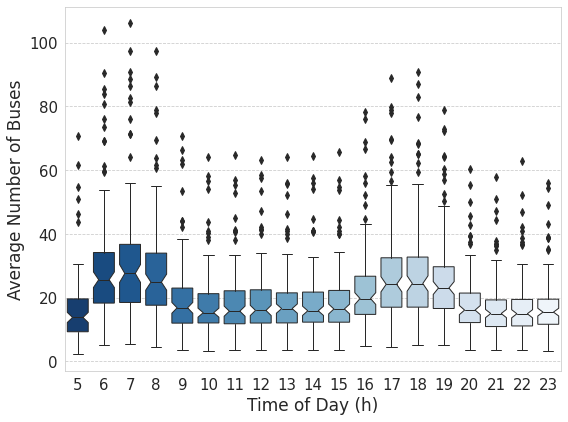

In [51]:
df = cluster_details.groupby(by = ["cluster", "hour"]).agg({"bus_availability": "mean"})
df.reset_index(inplace = True)

fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = df.hour, y = df.bus_availability, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(df.hour.unique())), notch = True, showfliers = True, ax = axes)
#axes.set_xticks(range(23));
g.tick_params(labelsize = 15)
g.set_xlabel("Time of Day (h)", fontsize = 17)
g.set_ylabel("Average Number of Buses", fontsize = 17);
plt.savefig('/home/julio/Downloads/cluster_avg_bus_availability.png', format='png', dpi=300)

In [40]:
df = pd.merge(cluster_metrics, dim_bus_stop, left_on = "centroid_legacy_id", right_on = "legacy_id")

In [41]:
df.sort_values(by = "cluster_bus_availability_mean", ascending = False)[["cluster","legacy_id","name", "centroid_mean_bus_availability", "centroid_bus_lines", "cluster_bus_availability_mean", "cluster_bus_lines", "cluster_size", "cluster_mean_distance_from_centre"]].head(10)

,cluster,legacy_id,name,centroid_mean_bus_availability,centroid_bus_lines,cluster_bus_availability_mean,cluster_bus_lines,cluster_size,cluster_mean_distance_from_centre
3,3,110026,"Rua Alferes Poli, 400 - Rebouças",5.71,20,72.41,53,54,410.82
0,0,150330,"Av. Winston Churchill, 2546 - Capão Raso",8.50,23,71.72,31,34,365.42
18,18,110016,"Rua Cruz Machado, 301 - Centro",3.54,10,70.62,67,122,444.39
12,12,110121,"Av. Cândido de Abreu, 501 - Centro Cívico",4.03,13,65.10,35,39,387.37
11,11,108035,Estação Tubo Bento Viana,4.22,4,57.10,31,36,379.62
14,14,160024,"Rua Isaac Ferreira da Cruz, 3351 - Sítio Cercado",3.89,8,54.77,24,51,334.03
8,8,108052,Estação Tubo Itajubá,4.36,6,53.78,25,42,455.25
5,5,180075,"Rua Pedro Gusso, 4093 - Cidade Industrial",5.51,11,52.88,18,43,359.39
20,20,109030,Estação Tubo Guadalupe,3.36,5,50.29,46,47,365.46
31,31,160096,"Rua Tijucas do Sul, 1070 - Sítio Cercado",3.10,5,46.21,10,28,379.33


In [42]:
import scipy

scipy.stats.pearsonr(x = cluster_metrics.cluster_bus_availability_mean, y = cluster_metrics.cluster_bus_lines)

(0.781613969148726, 1.2385800209737322e-22)

In [43]:
## Correlacoes por faixa de horario
## Rodar as correlações em um período determinado: 6 às 9, 11 às 14 e 17 às 20 (júlio / altieris)


In [77]:
def generate_correlations(cluster, hour, plot_name, time_window, directory):

    cluster0 = bus_stop_clustered.query(f"cluster == {cluster}").legacy_id.to_list()
    centroid = bus_stop_clustered.query(f"cluster == {cluster} and centre ==1").legacy_id.values[0]
    
    #if centroid != 170121:
    #    return
    
    #fig, axes = plt.subplots(figsize = (10, 8))

    #data = df_bus_availability.query(f"dummy_legacy_id in @cluster0 and hour in {hour}").filter(['dummy_legacy_id','hour','bus_availability']).pivot(index=['hour'], columns=['dummy_legacy_id'], values=['bus_availability']).sort_values(by='hour', ascending=False)
    data = paradas.query(f"dummy_legacy_id in @cluster0 and hour in {hour}").copy()
    data = data.groupby(['dummy_legacy_id','time_window']).agg(bus_availability=('bus_availability','mean')).reset_index()
    data = data.pivot(index=['time_window'], columns=['dummy_legacy_id'], values=['bus_availability']).sort_values(by='time_window', ascending=False)
    
    data.columns = data.columns.droplevel(level=0)
    data.columns.name = ''

    corr = data.corr().dropna(how='all', axis=1).dropna(how='all')
    #mask = np.triu(np.ones_like(corr, dtype=bool))
    #cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) 
    #g = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True,annot=False, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1, vmax=1)
    #image = g.get_figure()
    #plt.yticks(rotation=0)
    #plt.xticks(rotation=90)
    #plt.tick_params(labelsize = 15)
    #g.figure.axes[-1].tick_params(labelsize = 15)

    #image.savefig(f"correlations/{centroid}-{plot_name}.png", bbox_inches='tight', pad_inches=0.2)
    #image.savefig(f"correlations/{centroid}-{plot_name}-{time_window}.png", bbox_inches='tight', pad_inches=0.2)

    if len(corr):
        max_corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
        correlation_df = pd.DataFrame({
            'busstop_a': [pair[0] for pair in max_corr.index],
            'busstop_b': [pair[1] for pair in max_corr.index],
            'correlation': max_corr.values
        })

        #correlation_df.query("busstop_a != busstop_b and  (~correlation.isna())").to_csv(f"correlations/{centroid}-{plot_name}.csv", index=False)
        correlation_df.query("busstop_a != busstop_b and  (~correlation.isna())").to_csv(f"{directory}/{centroid}-{plot_name}-{time_window}.csv", index=False)

In [45]:
clusters = df.sort_values(by = "cluster_bus_availability_mean", ascending = False)[["cluster","legacy_id","name", "centroid_mean_bus_availability", "centroid_bus_lines", "cluster_bus_availability_mean", "cluster_bus_lines", "cluster_size", "cluster_mean_distance_from_centre"]]

<h3>correlations_1</h3>

Morning: [6,7,8]      
Afternoon: [11,12,13]<br>
Evening: [17,18,19]<br>
Agg: Time_Window

<h3>correlations_2</h3>

Morning: [6,7,8]      
Afternoon: [11,12,13]<br>
Evening: [17,18,19]<br>
Agg: 60 minutos

<h3>correlations_3</h3>

Early Morning: [6,7,8]<br>
Morning: [9,10,11]<br>
Afternoon: [12,13,14,15]<br>
Evening: [16,17,18,19]<br>
Agg: Time_Window

<h3>correlations_4</h3>

Early Morning: [6,7,8]<br>
Morning: [9,10,11]<br>
Afternoon: [12,13,14,15]<br>
Evening: [16,17,18,19]<br>
Agg: 60 minutos

<h3>correlations_5</h3>

Morning: [6,7,8,9]      
Afternoon: [11,12,13,15]<br>
Evening: [17,18,19,20]<br>
Agg: 60 minutos

In [90]:
# ----------------------------------------------------------
# Contabiliza a passagem dos veículos nos pontos de ônibus
# Notice that here we are using dummy legacy id's so all bus stops in the same bus terminal will be grouped as a single point
# ----------------------------------------------------------
directory = "correlations_5"
for time_window in range(45, 50, 5):
    paradas = []
    for legacy_id in vw_event["dummy_legacy_id"].unique():
        aux = vw_event.query("dummy_legacy_id == @legacy_id").copy()
        aux["bus_availability"] = 1
        aux.index = aux["event_timestamp"]
        aux.sort_index(inplace = True)
        aux = aux.rolling(window = "{0}min".format(time_window), min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
        aux.reset_index(inplace = True)
        aux["dummy_legacy_id"] = legacy_id
        aux["hour"] = aux["event_timestamp"].dt.hour
        aux["time_window"] = (100 * aux["event_timestamp"].dt.hour + aux["event_timestamp"].dt.minute).floordiv(60)
        paradas.append(aux)
    paradas = pd.concat(paradas, ignore_index = True)

    for row in clusters.itertuples():
        cluster = row.cluster
        
        generate_correlations(cluster=cluster, hour=[6,7,8,9], plot_name='Morning', time_window=time_window, directory=directory)
        generate_correlations(cluster=cluster, hour=[11,12,13,14], plot_name='Afternoon', time_window=time_window, directory=directory)
        generate_correlations(cluster=cluster, hour=[17,18,19,20], plot_name='Evening', time_window=time_window, directory=directory)
        
        #generate_correlations(cluster=cluster, hour=[6,7,8], plot_name='Early Morning', time_window=time_window, directory=directory)
        #generate_correlations(cluster=cluster, hour=[9,10,11], plot_name='Morning', time_window=time_window, directory=directory)
        #generate_correlations(cluster=cluster, hour=[12,13,14,15], plot_name='Afternoon', time_window=time_window, directory=directory)
        #generate_correlations(cluster=cluster, hour=[16,17,18,19], plot_name='Evening', time_window=time_window, directory=directory)

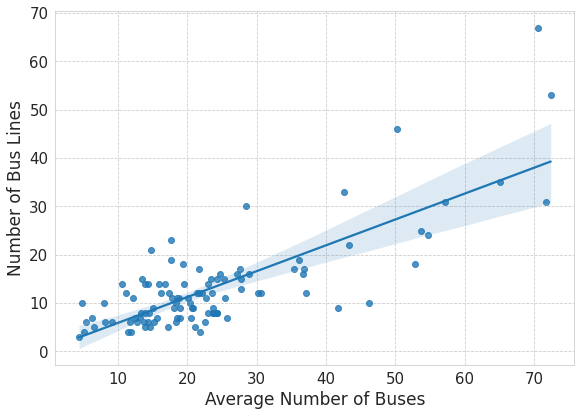

In [44]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = cluster_metrics.cluster_bus_availability_mean, y = cluster_metrics.cluster_bus_lines, ci = 95, ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Average Number of Buses", fontsize = 17)
g.set_ylabel("Number of Bus Lines", fontsize = 17);
plt.savefig('/home/julio/Downloads/corr_bus_aval_lines.png', format='png', dpi=300)

In [56]:
mostra_apenas_mapa_calor = False
mostra_apenas_centroid = True

colecao_pontos = []
for index, bus_stop in pd.merge(top, dim_bus_stop, left_on = "dummy_legacy_id", right_on = "legacy_id").iterrows():
    p = Point(bus_stop["longitude"], bus_stop["latitude"])
    colecao_pontos.append({
        "latlong": (p.y, p.x),
        "lat": p.y,
        "long": p.x,
        "geometry": p,
        "weight": bus_stop["mean_bus_availability"]
    })
pontos_calor = gpd.GeoDataFrame(colecao_pontos, crs = "epsg:4326")

colecao_pontos = []
for index, bus_stop in bus_stop_clustered.query("cluster in [0, 1, 2, 3, 4]").iterrows():
    p = Point(bus_stop["longitude"], bus_stop["latitude"])
    colecao_pontos.append({
        "latlong": (p.y, p.x),
        "lat": p.y,
        "long": p.x,
        "geometry": p,
        "centre": bus_stop["centre"]
    })
pontos = gpd.GeoDataFrame(colecao_pontos, crs = "epsg:4326")

mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap"
)
#HeatMap(pontos_calor[["lat", "long", "weight"]].to_numpy()).add_to(mapa)

if not mostra_apenas_mapa_calor:
    if not mostra_apenas_centroid:

        #marker_cluster = MarkerCluster().add_to(mapa)

        folium.GeoJson(
            pontos.query("centre == 0"),
            marker = folium.Marker(
                icon = folium.Icon(
                    color = "blue",
                    prefix = "fa",
                    icon = "bus"
                )
            )
        ).add_to(mapa)

    folium.GeoJson(
        pontos.query("centre == 1"),
        marker = folium.Marker(
            icon = folium.Icon(
                color = "red",
                prefix = "fa",
                icon = "bus"
            )
        )
    ).add_to(mapa)

plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa

In [54]:
bus_stop_clustered.query("cluster == 0").head(30)

,legacy_id,centre,d,cluster,id,name,latitude,longitude,type,type_norm
0,108123,0,165.16,0,7620,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
1,108124,0,164.60,0,7621,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
2,150270,0,355.95,0,10571,"Rua Engenheiro João Bley Filho, 95 - Pinheirinho",-25.52,-49.29,Chapéu chinês,Street bus stop
3,150271,0,470.50,0,10572,"Rua Hélio Dirceu Woitikiw, 122 - Pinheirinho",-25.52,-49.29,Domus,Street bus stop
4,150272,0,88.59,0,10573,"Rua André Ferreira Barbosa, 8391 - Pinheirinho",-25.52,-49.29,Novo mobiliário,Street bus stop
5,150330,1,0.00,0,10630,"Av. Winston Churchill, 2546 - Capão Raso",-25.52,-49.30,Domus,Street bus stop
6,150331,0,99.65,0,10631,"Av. Winston Churchill, 2472 - Capão Raso",-25.52,-49.30,Domus,Street bus stop
7,150332,0,460.74,0,10632,"Rua Léon Nicolas, 2081 - Capão Raso",-25.52,-49.29,Domus,Street bus stop
8,150334,0,315.54,0,10633,"Rodovia BR476, 19401 - Pinheirinho",-25.52,-49.29,Sem demarcação,Street bus stop
9,150751,0,167.12,0,10969,"Av. Winston Churchill, 2677 - Capão Raso",-25.52,-49.30,Placa em poste,Street bus stop


In [82]:
bus_stop_clustered.head()

,legacy_id,centre,d,cluster,id,name,latitude,longitude,type,type_norm
0,108123,0,165.16,0,7620,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
1,108124,0,164.60,0,7621,Estação Tubo Winston Churchill,-25.52,-49.30,Estação tubo,Tube station
2,150270,0,355.95,0,10571,"Rua Engenheiro João Bley Filho, 95 - Pinheirinho",-25.52,-49.29,Chapéu chinês,Street bus stop
3,150271,0,470.50,0,10572,"Rua Hélio Dirceu Woitikiw, 122 - Pinheirinho",-25.52,-49.29,Domus,Street bus stop
4,150272,0,88.59,0,10573,"Rua André Ferreira Barbosa, 8391 - Pinheirinho",-25.52,-49.29,Novo mobiliário,Street bus stop


In [84]:
top.head()

,dummy_legacy_id,type_norm,mean_bus_availability
0,150330,Street bus stop,8.50
1,150332,Street bus stop,8.48
2,150751,Street bus stop,8.37
3,150331,Street bus stop,8.10
4,170121,Street bus stop,6.09


In [48]:
import os
import glob
from os.path import join
from pathlib import Path

csv_files = glob.glob(join("correlations_5", "*.csv"))

correlations = []
for f in csv_files:
    aux = Path(f).stem.split("-")
    data = pd.read_csv(f)
    data["centre"] = aux[0]
    data["turno"] = aux[1]
    data["time_window"] = aux[2]
    correlations.append(data)

correlations = pd.concat(correlations, ignore_index = True)
correlations["centre"] = correlations["centre"].astype(np.int64)
correlations["time_window"] = correlations["time_window"].astype(np.int64)
correlations.turno = correlations.turno.replace("Afternoon", "Midday")
#correlations.query("time_window == 10", inplace = True)

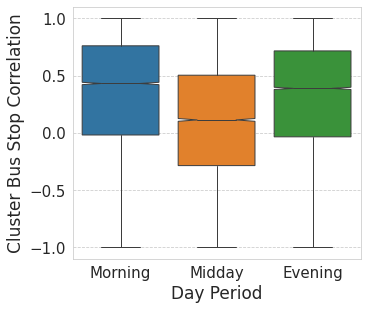

In [5]:
fig, axes = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
#g = sns.boxplot(x = correlations.turno, y = correlations.correlation, linewidth = 1.0, notch = True, showfliers = True, order = ["Early Morning", "Morning", "Afternoon", "Evening"], palette = sns.color_palette("tab10", 4), ax = axes)
g = sns.boxplot(x = correlations.turno, y = correlations.correlation, linewidth = 1.0, notch = True, showfliers = True, order = ["Morning", "Midday", "Evening"], palette = sns.color_palette("tab10", 3), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Day Period", fontsize = 17)
g.set_ylabel("Time Series Correlation", fontsize = 17);
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
fig.savefig('/home/julio/Downloads/cluster_bus_stop_correlation.png', format='png', dpi=300)

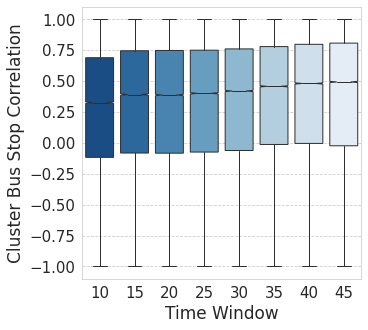

In [93]:
fig, axes = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = correlations.time_window, y = correlations.correlation, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(correlations.time_window.unique())), notch = True, showfliers = True, ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Cluster Bus Stop Correlation", fontsize = 17);
fig.savefig('correlation_time_window.png', format='png', dpi=300)

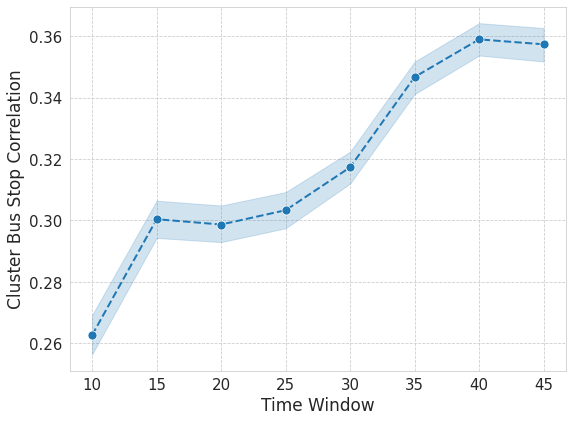

In [94]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = correlations.time_window, y = correlations.correlation, estimator='mean', err_style = 'band', ci = 99, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Cluster Bus Stop Correlation", fontsize = 17)
plt.savefig('correlation_time_window.png', format='png', dpi=300);

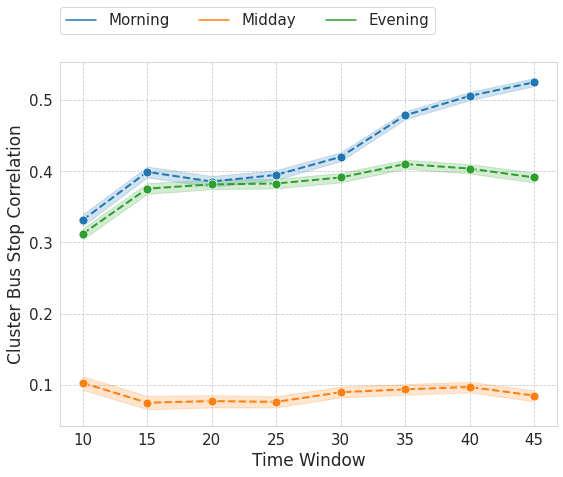

In [120]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
#g = sns.lineplot(x = correlations.time_window, y = correlations.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = correlations.turno, hue_order = ["Early Morning", "Morning", "Afternoon", "Evening"], palette = sns.color_palette("tab10", 4), ax = axes)
g = sns.lineplot(x = correlations.time_window, y = correlations.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = correlations.turno, hue_order = ["Morning", "Midday", "Evening"], palette = sns.color_palette("tab10", 3), ax = axes)
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Cluster Bus Stop Correlation", fontsize = 17)
plt.savefig('/home/julio/Downloads/correlation_time_window.png', format='png', dpi=300);

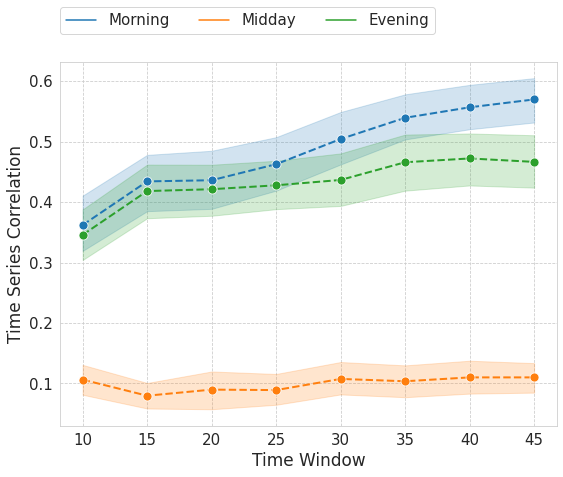

In [50]:
a = correlations.groupby(by = ["centre", "turno", "time_window"]).agg({"correlation": "mean"})
a.reset_index(inplace = True)
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
#g = sns.lineplot(x = a.time_window, y = a.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = a.turno, hue_order = ["Early Morning", "Morning", "Afternoon", "Evening"], palette = sns.color_palette("tab10", 4), ax = axes)
g = sns.lineplot(x = a.time_window, y = a.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = a.turno, hue_order = ["Morning", "Midday", "Evening"], palette = sns.color_palette("tab10", 3), ax = axes)
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Time Series Correlation", fontsize = 17)
plt.savefig('/home/julio/Downloads/correlation_time_window.png', format='png', dpi=300);

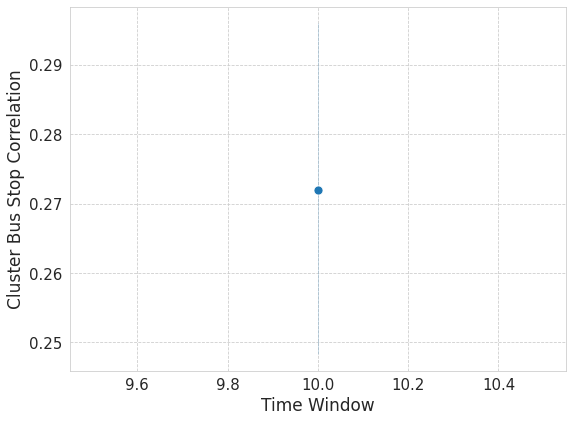

In [67]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = a.time_window, y = a.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, palette = sns.color_palette("tab10", 3), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Cluster Bus Stop Correlation", fontsize = 17)
plt.savefig('bus_availability.png', format='png', dpi=300);

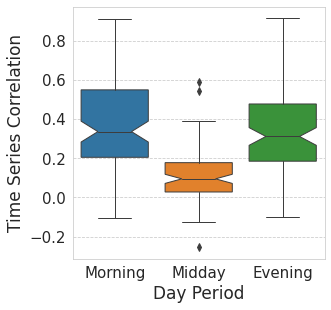

In [47]:
fig, axes = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
#g = sns.boxplot(x = a.turno, y = a.correlation, linewidth = 1.0, notch = True, showfliers = True, order = ["Early Morning", "Morning", "Afternoon", "Evening"], palette = sns.color_palette("tab10", 4), ax = axes)
g = sns.boxplot(x = a.turno, y = a.correlation, linewidth = 1.0, notch = True, showfliers = True, order = ["Morning", "Midday", "Evening"], palette = sns.color_palette("tab10", 3), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Day Period", fontsize = 17)
g.set_ylabel("Time Series Correlation", fontsize = 17);
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
fig.savefig('/home/julio/Downloads/cluster_bus_stop_correlation.png', format='png', dpi=300)

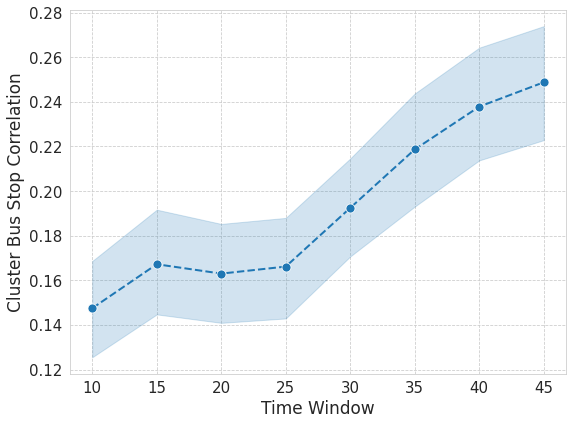

In [166]:
a = correlations.groupby(by = ["centre", "turno", "time_window"]).agg({"correlation": "mean"})
a.reset_index(inplace = True)
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = a.time_window, y = a.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, palette = sns.color_palette("tab10", 3), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Time Window", fontsize = 17)
g.set_ylabel("Cluster Bus Stop Correlation", fontsize = 17)
plt.savefig('bus_availability.png', format='png', dpi=300);

In [154]:
aux = correlations.query("turno in ['Evening', 'Morning']").groupby(by = ["centre"]).agg({"correlation": "mean"})
aux.reset_index(inplace = True)
aux = pd.merge(cluster_metrics, aux, left_on = "centroid_legacy_id", right_on = "centre")

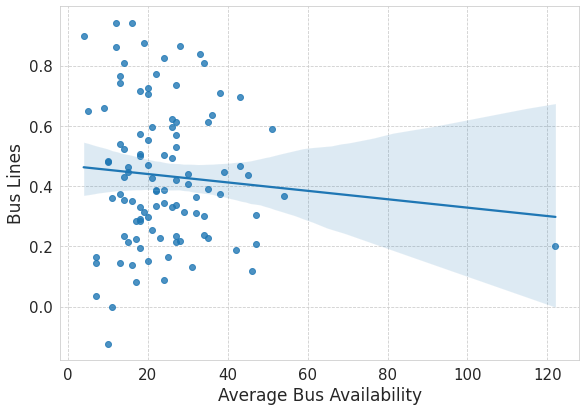

In [148]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = aux.cluster_size, y = aux.correlation, ci = 95, ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Average Bus Availability", fontsize = 17)
g.set_ylabel("Bus Lines", fontsize = 17);
plt.savefig('corr_bus_aval_lines.png', format='png', dpi=300)

In [130]:
scipy.stats.pearsonr(x = aux.cluster_size, y = aux.correlation)

(-0.08642227393238015, 0.3853879782508863)

In [153]:
bus_stop_clustered.cluster.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103])

In [159]:
aux.sort_values(by = "correlation", ascending = True).head(50)

,cluster,cluster_bus_availability_mean,cluster_bus_lines,cluster_size,cluster_mean_distance_from_centre,centroid_legacy_id,centroid_mean_bus_availability,centroid_bus_lines,centre,correlation
2,2,13.41,15,10,372.43,160072,5.91,14,160072,-0.12
55,56,11.74,6,11,378.96,108208,2.59,3,108208,-0.00
98,99,6.21,7,7,232.55,180072,2.08,5,180072,0.03
21,22,18.80,11,17,342.84,108044,3.35,4,108044,0.08
49,50,19.38,18,24,307.06,109046,2.66,3,109046,0.09
47,48,28.94,16,46,363.12,190239,2.70,7,190239,0.12
42,43,23.54,12,31,374.92,110033,2.89,8,110033,0.13
16,17,14.75,21,16,427.52,110210,3.57,11,110210,0.14
70,71,8.06,10,13,307.34,130203,2.30,5,130203,0.14
6,6,11.22,12,7,406.29,170490,4.70,11,170490,0.15


In [162]:
aux.query("cluster == 1")

,cluster,cluster_bus_availability_mean,cluster_bus_lines,cluster_size,cluster_mean_distance_from_centre,centroid_legacy_id,centroid_mean_bus_availability,centroid_bus_lines,centre,correlation
1,1,43.38,22,15,386.65,170121,6.09,15,170121,0.45


In [163]:
df_bus_availability.head()

,dummy_legacy_id,name_normalized,type_norm,hour,bus_availability
0,101001,,Street bus stop,5,1.00
1,101001,,Street bus stop,6,1.00
2,101001,,Street bus stop,7,1.00
3,101001,,Street bus stop,8,1.00
4,101001,,Street bus stop,9,1.00


In [167]:
aux = correlations.groupby(by = ["centre", "turno"]).agg({"correlation": "mean"})
aux.reset_index(inplace = True)

In [172]:
aux.query("centre == 170121")

,centre,turno,correlation
237,170121,Afternoon,-0.02
238,170121,Evening,0.57
239,170121,Morning,0.32


In [47]:
paradas.head(1)

,event_timestamp,bus_availability,dummy_legacy_id,hour
0,2022-07-11 05:18:59,1.00,180899,5


In [60]:
legacy_ids = list(clusters.legacy_id.to_numpy())
aux = vw_event.query("dummy_legacy_id in @legacy_ids").copy()
aux["hour"] = aux["event_timestamp"].dt.hour
aux.groupby(by = "hour")["vehicle"].nunique()

hour
5      865
6     1200
7     1220
8     1205
9      934
10     860
11     877
12     888
13     888
14     884
15     943
16    1172
17    1217
18    1216
19    1167
20     876
21     776
22     778
23     775
Name: vehicle, dtype: int64

In [47]:
vw_event.vehicle.drop_duplicates().count()

1294

In [79]:
bus_stop_clustered.to_csv("bus_stop_clustered.csv", index = False)